In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC


In [18]:
# Path to the ZipDigits.train file
file_path = 'ZipDigits.train'

# Load the data from the file
data = []

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        values = list(map(float, line.split()))  # Convert each line to a list of floats
        data.append(values)

# Convert the list to a NumPy array for easier manipulation
data = np.array(data)

# Split the data into labels (first column) and features (remaining columns)
labels = data[:, 0]      # Labels are the first column
features = data[:, 1:]   # Features are the remaining columns

# Display the shape of features and labels
print(f'Features shape: {features.shape}')
print(f'Labels shape: {labels.shape}')

Features shape: (7291, 256)
Labels shape: (7291,)


In [19]:
# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print(X_train.shape)

(5832, 256)


In [20]:
def filter_relevant_data(X_train, y_train, X_test, y_test):
    """
    Filters the dataset to keep only the samples corresponding to the digits 1 and 5.

    :param X_train: Training data (numpy array of shape (n_samples_train, n_features))
    :param y_train: Training labels (numpy array of shape (n_samples_train,))
    :param X_test: Test data (numpy array of shape (n_samples_test, n_features))
    :param y_test: Test labels (numpy array of shape (n_samples_test,))
    :return: X_train_f, y_train_f, X_test_f, y_test_f: Filtered training and test sets
             containing only samples where the labels are 1 or 5.
    """
    # Filter the training data for labels 1 and 5
    train_filter = np.isin(y_train, [1, 5])
    X_train_f = X_train[train_filter]
    y_train_f = y_train[train_filter]

    # Filter the test data for labels 1 and 5
    test_filter = np.isin(y_test, [1, 5])
    X_test_f = X_test[test_filter]
    y_test_f = y_test[test_filter]

    # Return the filtered data
    return X_train_f, y_train_f, X_test_f, y_test_f

In [21]:
X_train_f,y_train_f,X_test_f,y_test_f=filter_relevant_data(X_train,y_train,X_test,y_test)

In [22]:
print(X_train_f.shape)

(1233, 256)


In [23]:
# Function to calculate vertical symmetry
def vertical_symmetry(image):
    left_half = image[:, :8]  # Left half (first 8 columns)
    right_half = np.fliplr(image[:, 8:])  # Right half, flipped horizontally
    symmetry = np.mean(np.abs(left_half - right_half))  # Mean absolute difference
    return symmetry

# Function to calculate horizontal symmetry
def horizontal_symmetry(image):
    top_half = image[:8, :]  # Top half (first 8 rows)
    bottom_half = np.flipud(image[8:, :])  # Bottom half, flipped vertically
    symmetry = np.mean(np.abs(top_half - bottom_half))  # Mean absolute difference
    return symmetry

# Function to calculate the width (using a threshold to determine pixel activation)
def width(image, threshold=0.5):
    # Count non-zero pixels (greater than threshold) along the columns
    width = np.sum(np.max(image > threshold, axis=0))
    return width

def intensity(image):
    return np.mean(X_train)

# Main function to apply feature transform
def feature_transform(X,func1,func2):
    """
    Applies feature transformations to each image in X and returns a 1D numpy array
    with a single feature value per image.
    
    :param X: numpy array of shape (n_samples, 256), where each row is a flattened 16x16 image
    :return: numpy array of shape (n_samples,) containing one feature value per image
    """
    # Initialize list to store the transformed features
    transformed_features = []

    # Loop over each image (flattened) in X
    for i in range(X.shape[0]):
        image = X[i].reshape(16, 16)  # Reshape the 256 feature vector to 16x16
        
        # Calculate the feature transform
        #vertical_symmetry = calculate_vertical_symmetry(image)
        #horizontal_symmetry = calculate_horizontal_symmetry(image)
        #width = calculate_width(image)
        
        # For simplicity, let's combine these features (you can choose how to combine them)
        # For this example, we'll just use the width as the feature, but you can customize this
        #feature_value = func(image)
        
        # Append the calculated feature to the list
        features=[func1(image),func2(image)]
        transformed_features.append(features)

    # Convert the list to a numpy array and return
    return np.array(transformed_features)

In [24]:
X_train_new=feature_transform(X_train_f,horizontal_symmetry,intensity)
X_test_new=feature_transform(X_test_f,horizontal_symmetry,intensity)

In [25]:
def nonlinear_transform(X_train_transformed):
    """
    Applies a set of nonlinear transformations to the input array X_train_transformed.

    :param X_train_transformed: numpy array of shape (n_samples, 2), 
                                where each row represents a pair of features.
    :return: X_train_nonlin: numpy array with the nonlinear transformations applied.
    """
    # Extract the two columns/features from X_train_transformed
    x1 = X_train_transformed[:, 0]  # First feature
    x2 = X_train_transformed[:, 1]  # Second feature

    # Apply nonlinear transformations
    x1_squared = np.square(x1)         # x1^2
    x2_squared = np.square(x2)         # x2^2
    x1_cubed = np.power(x1, 3)         # x1^3
    x2_cubed = np.power(x2, 3)         # x2^3
    x1_exp = np.exp(x1)                # exp(x1)
    x2_exp = np.exp(x2)                # exp(x2)
    x1_sin = x1+x2_squared                # x1+x2^2
    x2_sin = x2+x1_squared                # x2+x1^2
    x1x2=x1*x2
    x12_x23=x1_squared+x2_cubed

    # Combine all transformations into a new feature matrix
    X_train_nonlin = np.column_stack((x1, x2, x1_squared, x2_squared, x1_cubed, x2_cubed, x1_exp, x2_exp, x1_sin, x2_sin,x1x2,x12_x23))

    # Return the transformed array
    return X_train_nonlin

In [26]:
X_train_trans=nonlinear_transform(X_train_new)
X_test_trans=nonlinear_transform(X_test_new)

In [27]:


def svm_fit_and_test(X_train_transformed, y_train, X_test_transformed, y_test,C=1):
    """
    Trains an SVM on the nonlinear transformed training data and tests its accuracy.
    
    :param X_train_transformed: Transformed training data (numpy array)
    :param y_train: Training labels (numpy array)
    :param X_test_transformed: Transformed test data (numpy array)
    :param y_test: Test labels (numpy array)
    :return: accuracy: The accuracy of the SVM on the test data.
    """
    # Apply nonlinear transform to both train and test data
    X_train_nonlin = nonlinear_transform(X_train_transformed)
    X_test_nonlin = nonlinear_transform(X_test_transformed)
    
    # Initialize the SVM classifier
    svm_model = SVC(kernel='rbf',C=C)  # RBF kernel (default), can use others like 'linear', 'poly', 'sigmoid'
    
    # Fit the SVM model on the training data
    svm_model.fit(X_train_nonlin, y_train)
    
    # Predict the labels on the test set
    y_pred = svm_model.predict(X_test_nonlin)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return the accuracy
    return accuracy

# Example usage:
# Assuming X_train_transformed and X_test_transformed are (5500, 2) and (500, 2)
# Assuming y_train and y_test are the labels for the training and test sets

# Fit SVM and get accuracy
accuracy = svm_fit_and_test(X_train_trans, y_train_f, X_test_trans, y_test_f)

# Output the accuracy
print(f"SVM Accuracy: {accuracy * 100:.2f}%")

SVM Accuracy: 99.70%


In [28]:
def plot_digit_image(index):
    """
    Plots the digit image at a given index from the features and labels.
    
    :param index: The index of the digit to plot (0 to len(features)-1)
    """
    # Reshape the features into a 16x16 image
    image = features[index].reshape(16, 16)
    
    # Get the corresponding label
    label = int(labels[index])
    
    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

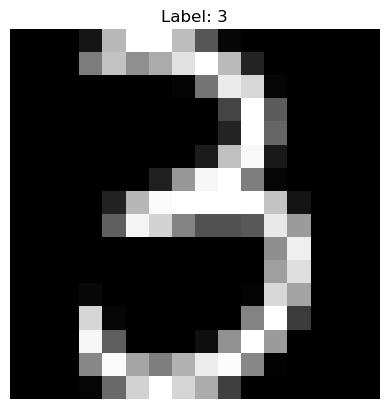

In [29]:
plot_digit_image(6)